In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc

# Import Dataset

In [2]:
ifmha = pd.read_csv('./tauraat-230322-150349.csv', converters={'site_no': str}, low_memory=False)
ifmha.shape

(2064782, 49)

In [3]:
candidate_columns = ['chan_width', 'chan_discharge', 'chan_area', 'SLOPE','chan_max_depth']
ifmha = ifmha[(ifmha[candidate_columns] > 0).all(axis=1)]
ifmha.shape

(2064720, 49)

In [4]:
from sklearn.linear_model import LinearRegression
import time

In [5]:
t1 = time.time()
# Side Slope (Ss):
ifmha_ss = ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)
# Bottom Width (Bw):
ifmha_bw =  ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).intercept_[0] * 2.0).reset_index(drop=False)
ifmha = pd.merge(ifmha, ifmha_ss, how="left", on=["site_no"])
ifmha = pd.merge(ifmha, ifmha_bw, how="left", on=["site_no"])
print(time.time() - t1)

12.380099534988403


In [6]:
ifmha.rename(columns={'0_x': 'side_slope', '0_y': 'chan_bottom_width'}, inplace=True)

In [7]:
ifmha.head()

,site_no,COMID,DASqKm,DASqMi,FTYPE,LatSite,LonSite,SLOPE,STATE,STATE_CD,...,site_visit_coll_agency_cd,station_nm,streamflow_method,tz_cd,velocity_method,vert_vel_desc,chan_mean_depth,chan_max_depth,side_slope,chan_bottom_width
0,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",unspe,NaN,unkno,UNSP,0.766562,1.107819,10.49578,239.025255
1,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",QSCMM,NaN,unkno,UNSP,2.612188,3.837696,10.49578,239.025255
2,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",unspe,EDT,unkno,UNSP,1.766667,2.587080,10.49578,239.025255
3,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",unspe,NaN,unkno,UNSP,0.962617,1.397805,10.49578,239.025255
4,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",QSCMM,NaN,unkno,UNSP,0.821429,1.188973,10.49578,239.025255


In [7]:
ifmha = ifmha[(ifmha['side_slope'] <= 12.0) & (ifmha['chan_bottom_width'] >= 0.0)]
ifmha.shape

(1970542, 51)

In [8]:
ifmha['site_no'].value_counts().describe()

count    6169.000000
mean      319.426487
std       271.648396
min        50.000000
25%       154.000000
50%       259.000000
75%       390.000000
max      6580.000000
Name: site_no, dtype: float64

In [9]:
ifmha['wetted_perimeter'] = ifmha['chan_bottom_width'] + (2 * ifmha['chan_max_depth'] * (1 + ifmha['side_slope']**2)**0.5)
ifmha['hydraulic_radius'] = ifmha['chan_area'] / ifmha['wetted_perimeter']
# tauraat['wetted_perimeter'] = tauraat['chan_width'] + 2 * tauraat['chan_mean_depth']

In [10]:
ifmha['manning_roughness'] = (1.49 * ifmha['SLOPE']**0.5 * ifmha['chan_area']**(5.0/3.0)) / (ifmha['chan_discharge'] * ifmha['wetted_perimeter']**(2.0/3.0))
ifmha['jarrett_roughness'] = 0.39 * ifmha['SLOPE']**0.38 * ifmha['hydraulic_radius']**-0.16

In [11]:
ifmha_subset = ifmha[(ifmha['SLOPE']>0.002) & (ifmha['SLOPE']<0.04) & (ifmha['hydraulic_radius'] > 0.5)]
ifmha_subset['site_no'].value_counts().describe()

count    2137.000000
mean      244.973795
std       187.158591
min        16.000000
25%       112.000000
50%       198.000000
75%       318.000000
max      2201.000000
Name: site_no, dtype: float64

In [12]:
manning_n = ifmha.groupby('site_no').apply(lambda x: x['manning_roughness'].median() if x['manning_roughness'].median() < 0.2 else np.nan).reset_index(drop=False).rename(columns={0: 'roughness'})
jarret_n = ifmha_subset.groupby('site_no').apply(lambda x: x['jarrett_roughness'].median()).reset_index(drop=False).rename(columns={0: 'roughness'})

In [13]:
manning_n_com =  manning_n[manning_n['site_no'].isin(jarret_n['site_no'].tolist())]
jarret_n_com =  jarret_n[jarret_n['site_no'].isin(manning_n['site_no'].tolist())]

In [22]:
manning_n_com[~manning_n_com['roughness'].isna()].shape

(1895, 2)

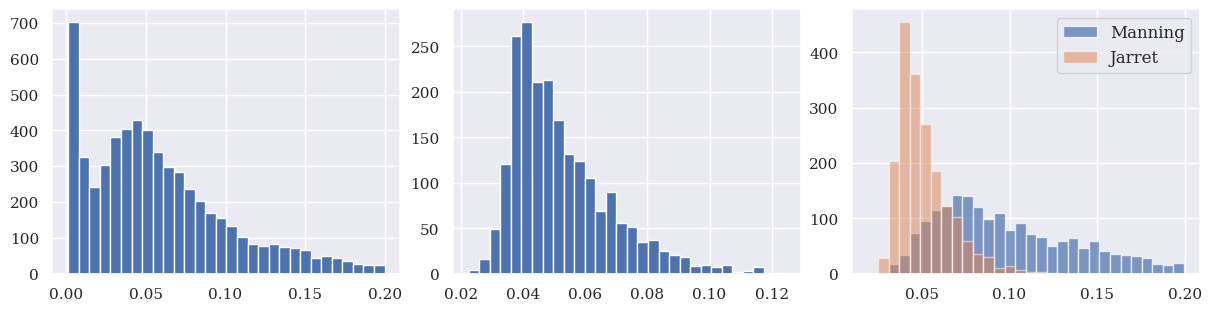

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    'font.size'   : 40
})

# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 200}
#
# matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 3), constrained_layout=True)

ax1.hist(manning_n['roughness'].values, bins=30)
ax2.hist(jarret_n['roughness'].values, bins=30)
data1 = manning_n_com[~manning_n_com['roughness'].isna()]
data2 = jarret_n_com[jarret_n_com['site_no'].isin(data1['site_no'].tolist())]
ax3.hist(data1['roughness'].values, bins=30, range=(np.min(data1['roughness']), np.max(data1['roughness'])), alpha=0.7, label= "Manning" )
ax3.hist(data2['roughness'].values, bins=30, range=(np.min(data1['roughness']), np.max(data1['roughness'])), alpha=0.5, label="Jarret")
ax3.legend(fontsize=12)

plt.savefig(f'./roughness.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [24]:
# https://www.hydroshare.org/resource/0a596929a3e5411bb0032a8de35e5089/
ds = nc.Dataset('./data/RouteLink_CONUS.nc/RouteLink_CONUS.nc')
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Convention: CF-1.6
    featureType: timeSeries
    processing_notes: This file was produced Fri Apr 12 07:16:15 2019 by Kevin Sampson (NCAR) and has the following attributes: 
   This file uses the NHDPlus v21 "flattened" geodatabase: NHDPlusV21_National_Flattened.gdb.
   This file excludes reaches in Puerto Rico and Hawaii.
   Routing using Arc-Hydro derived segments for Regions 01a, 02b, 09a, 10i, 10h, 13a, 13b, 13d, 15a, 15b, 17b, 18a.
   Topology fixes using: Topology_Fixer.csv.
   NHDFlowlines removed using: Remove_COMIDs_NHDFLowline_Network.csv.
   Gage preference list: numberOf100QualityObs.2017-03-15.csv.
   Gage subset list: numberOf100QualityObs.2017-03-15.csv.
   Gage additions made using: Add_Gage_Association.csv.
   Gage-to-flowline association changes made using: Bad_Gage_Associations.csv.
   Tidal-influenced gages removed using: TidalGageList_20170316.csv.
   Waterbody assoc

In [6]:
print(ds.__dict__)

{'Convention': 'CF-1.6', 'featureType': 'timeSeries', 'processing_notes': 'This file was produced Fri Apr 12 07:16:15 2019 by Kevin Sampson (NCAR) and has the following attributes: \n   This file uses the NHDPlus v21 "flattened" geodatabase: NHDPlusV21_National_Flattened.gdb.\n   This file excludes reaches in Puerto Rico and Hawaii.\n   Routing using Arc-Hydro derived segments for Regions 01a, 02b, 09a, 10i, 10h, 13a, 13b, 13d, 15a, 15b, 17b, 18a.\n   Topology fixes using: Topology_Fixer.csv.\n   NHDFlowlines removed using: Remove_COMIDs_NHDFLowline_Network.csv.\n   Gage preference list: numberOf100QualityObs.2017-03-15.csv.\n   Gage subset list: numberOf100QualityObs.2017-03-15.csv.\n   Gage additions made using: Add_Gage_Association.csv.\n   Gage-to-flowline association changes made using: Bad_Gage_Associations.csv.\n   Tidal-influenced gages removed using: TidalGageList_20170316.csv.\n   Waterbody associations using spatial join with Lake feature class Input_Waterbodies_NWM_v2_1.shp

In [8]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
int32 link(feature_id)
    long_name: Link ID (NHDFlowline_network COMID)
    cf_role: timeseries_id
    coordinates: lat lon
unlimited dimensions: 
current shape = (2776738,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
int32 from(feature_id)
    long_name: From Link ID (PlusFlow table FROMCOMID for every TOCOMID)
    coordinates: lat lon
unlimited dimensions: 
current shape = (2776738,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
int32 to(feature_id)
    long_name: To Link ID (PlusFlow table TOCOMID for every FROMCOMID)
    coordinates: lat lon
unlimited dimensions: 
current shape = (2776738,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(feature_id)
    long_name: longitude of the segment midpoint
    units: degrees_east
    standard_name: longitude
    coordinates: lat lon
unlimited dimensions: 
current shape =

In [25]:
ds_dict = {'COMID': ds['link'][:], 'side_slope': 1/ds['ChSlp'][:], 'bottom_width': ds['BtmWdth'][:], 'compound_manning': ds['nCC'][:], 'manning': ds['n'][:]}

In [26]:
nwm = pd.DataFrame.from_dict(ds_dict)

## Channel Side Slope & Bottom Width

In [27]:
ifmha_v1 = ifmha.drop_duplicates(subset='site_no', keep='first')
print(np.sum(ifmha_v1['COMID'].value_counts() > 1)) # counting number of COMIDS that includes more than one gage station

60


In [28]:
ifmha_v1 = ifmha_v1.groupby("COMID").apply(lambda x: x[['side_slope', 'chan_bottom_width']].mean()).reset_index(drop=False)

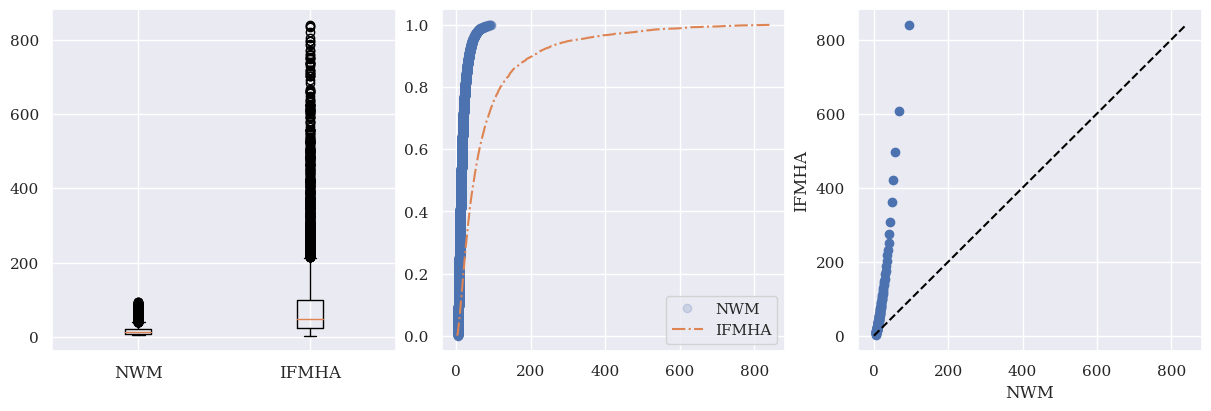

In [36]:
from utils import qqplot
data1 = ifmha_v1[ifmha_v1['COMID'].isin(nwm['COMID'].tolist())]['chan_bottom_width'].values
data2 = nwm[nwm['COMID'].isin(ifmha_v1['COMID'].tolist())]['bottom_width'].values

data1 = data1[(data1 > np.quantile(data1, 0.01)) & (data1 < np.quantile(data1, 0.99))]
data2 = data2[(data2 > np.quantile(data1, 0.01)) & (data2 < np.quantile(data2, 0.99))]

qqplot(data2, data1, axis_names=['NWM', 'IFMHA'], quantiles=100, site_name='bottom-width')